In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("../datasets/train_denoised.csv")

# 从 data 中随机抽样 10000 条
sampled_data = data.sample(n=10000, random_state=42)  # 设置 random_state 保证可复现

# 特征和目标
feature_cols = [
    'LAE71AA101ZZ.AV', 'A1SPRFLOW.AV', 'LAE72AA101ZZ.AV', 'B1SPRFLOW.AV',
    'LAE73AA101ZZ.AV', 'A2SPRFLOW.AV', 'LAE74AA101ZZ.AV', 'B2SPRFLOW.AV',
    'PSHAOUTTE.AV', 'PSHBOUTTE.AV'
]

# target_cols = ['SHAOUTTE.AV']
target_cols = ['SHBOUTTE.AV']

# 数据归一化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(sampled_data[feature_cols])
y = scaler_y.fit_transform(sampled_data[target_cols])

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 搜索最佳 n_estimators（树的数量）
param_grid_n_estimators = {
    'n_estimators': [10,40,70,100,130,150,170,180,190,200,210,220,230,240,250]
}

grid_search_n = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_n_estimators,
    cv=3,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_n.fit(X_train, y_train.ravel())  # y必须展平为1D向量

# ---------- 打印最佳参数 ----------
print("Best n_estimators:", grid_search_n.best_params_)

# ---------- 可视化 ----------
results = pd.DataFrame(grid_search_n.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(param_grid_n_estimators['n_estimators'], -results['mean_test_score'], marker='o', label='Validation MSE')
plt.plot(param_grid_n_estimators['n_estimators'], -results['mean_train_score'], marker='x', linestyle='--', label='Train MSE')

plt.xlabel("n_estimators (number of trees)")
plt.ylabel("Mean Squared Error")
plt.title("Grid Search on n_estimators")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 搜索最佳 n_estimators（树的数量）
# param_grid_n_estimators = {
#     'n_estimators': [80,81,82,83,84,85,86,87,88,89,90]
# }

param_grid_n_estimators = {
    'n_estimators': list(range(190, 211))
}

grid_search_n = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_n_estimators,
    cv=3,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_n.fit(X_train, y_train.ravel())  # y必须展平为1D向量

# ---------- 打印最佳参数 ----------
print("Best n_estimators:", grid_search_n.best_params_)

# ---------- 可视化 ----------
results = pd.DataFrame(grid_search_n.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(param_grid_n_estimators['n_estimators'], -results['mean_test_score'], marker='o', label='Validation MSE')
plt.plot(param_grid_n_estimators['n_estimators'], -results['mean_train_score'], marker='x', linestyle='--', label='Train MSE')

plt.xlabel("n_estimators (number of trees)")
plt.ylabel("Mean Squared Error")
plt.title("Grid Search on n_estimators")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 基于最佳 n_estimators 继续调 max_depth
param_grid_depth = {
    'max_depth': list(range(1, 21))  # 1 到 20
}

# 使用前一个搜索中找到的最佳 n_estimators
best_n = grid_search_n.best_params_['n_estimators']

grid_search_depth = GridSearchCV(
    RandomForestRegressor(n_estimators=best_n, random_state=42),
    param_grid_depth,
    cv=3,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_depth.fit(X_train, y_train.ravel())  # y需为1D向量

# ---------- 打印最佳参数 ----------
print("Best max_depth:", grid_search_depth.best_params_)

# ---------- 可视化 ----------
results_depth = pd.DataFrame(grid_search_depth.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(param_grid_depth['max_depth'], -results_depth['mean_test_score'], marker='o', label='Validation MSE')
plt.plot(param_grid_depth['max_depth'], -results_depth['mean_train_score'], marker='x', linestyle='--', label='Train MSE')

plt.xlabel("max_depth")
plt.ylabel("Mean Squared Error")
plt.title(f"Grid Search on max_depth (n_estimators={best_n})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
param_grid_split = {
    'min_samples_split': list(range(1, 11))  # 1 到 10
}

# 使用之前的最佳 n_estimators 和 max_depth
best_n = grid_search_n.best_params_['n_estimators']
best_depth = grid_search_depth.best_params_['max_depth']

grid_search_split = GridSearchCV(
    RandomForestRegressor(
        n_estimators=best_n, 
        max_depth=best_depth, 
        random_state=42
    ),
    param_grid_split,
    cv=2,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_split.fit(X_train, y_train.ravel())  # y需要是1D向量

# ---------- 打印最佳参数 ----------
print("Best min_samples_split:", grid_search_split.best_params_)

# ---------- 可视化 ----------
results_split = pd.DataFrame(grid_search_split.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(param_grid_split['min_samples_split'], -results_split['mean_test_score'], marker='o', label='Validation MSE')
plt.plot(param_grid_split['min_samples_split'], -results_split['mean_train_score'], marker='x', linestyle='--', label='Train MSE')

plt.xlabel("min_samples_split")
plt.ylabel("Mean Squared Error")
plt.title(f"Grid Search on min_samples_split (n_estimators={best_n}, max_depth={best_depth})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
param_grid_leaf = {
    'min_samples_leaf': list(range(1, 11))  # 最小样本数为 1、2 和 4
}


# 使用之前的最佳 n_estimators、max_depth 和 min_samples_split
best_n = grid_search_n.best_params_['n_estimators']
best_depth = grid_search_depth.best_params_['max_depth']
best_split = grid_search_split.best_params_['min_samples_split']

grid_search_leaf = GridSearchCV(
    RandomForestRegressor(
        n_estimators=best_n,
        max_depth=best_depth,
        min_samples_split=best_split,
        random_state=42
    ),
    param_grid_leaf,
    cv=2,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_leaf.fit(X_train, y_train.ravel())  # y必须是1D向量

# ---------- 打印最佳参数 ----------
print("Best min_samples_leaf:", grid_search_leaf.best_params_)

# ---------- 可视化 ----------
results_leaf = pd.DataFrame(grid_search_leaf.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(param_grid_leaf['min_samples_leaf'], -results_leaf['mean_test_score'], marker='o', label='Validation MSE')
plt.plot(param_grid_leaf['min_samples_leaf'], -results_leaf['mean_train_score'], marker='x', linestyle='--', label='Train MSE')

plt.xlabel("min_samples_leaf")
plt.ylabel("Mean Squared Error")
plt.title(f"Grid Search on min_samples_leaf (n_estimators={best_n}, max_depth={best_depth}, min_samples_split={best_split})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# 用最佳参数训练最终模型
best_model = RandomForestRegressor(random_state=42,n_estimators=207,max_depth=18,min_samples_split=2,min_samples_leaf=1) # A
# best_model = RandomForestRegressor(random_state=42,n_estimators=85,max_depth=16,min_samples_split=2,min_samples_leaf=1) # B
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


c:\Users\siming\miniconda3\envs\YOLO\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [12]:
# 还原预测结果
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 评估
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")

Test MSE: 18.2101


In [ ]:
# 最佳参数组合
best_params = {
    'n_estimators': grid_search_n.best_params_['n_estimators'],
    'max_depth': grid_search_depth.best_params_['max_depth'],
    'min_samples_split': grid_search_split.best_params_['min_samples_split'],
    'min_samples_leaf': grid_search_leaf.best_params_['min_samples_leaf'],
}

print("Best combined parameters:", best_params)

# 用最佳参数训练最终模型
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 还原预测结果
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# 评估
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")


In [ ]:
import joblib

# 保存训练好的模型
joblib.dump(best_model, './PKL/A_denoised.pkl')

# 同时保存特征和目标的 Scaler
joblib.dump(scaler_X, './PKL/A_denosied_X.pkl')
joblib.dump(scaler_y, './PKL/A_denosied_y.pkl')


['A_denosied_y.pkl']

In [ ]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载模型和 Scaler

best_model = joblib.load("./PKL/B_denoised.pkl")
scaler_X = joblib.load("./PKL/B_denosied_X.pkl")
scaler_y = joblib.load("./PKL/B_denosied_y.pkl")


# 特征列
feature_cols = [
    'LAE71AA101ZZ.AV', 'A1SPRFLOW.AV', 'LAE72AA101ZZ.AV', 'B1SPRFLOW.AV',
    'LAE73AA101ZZ.AV', 'A2SPRFLOW.AV', 'LAE74AA101ZZ.AV', 'B2SPRFLOW.AV',
    'PSHAOUTTE.AV','PSHBOUTTE.AV'
]





Test MSE: 85.9328
RMSE: 9.2700
R2 Score: 0.9978
MAE: 5.5283


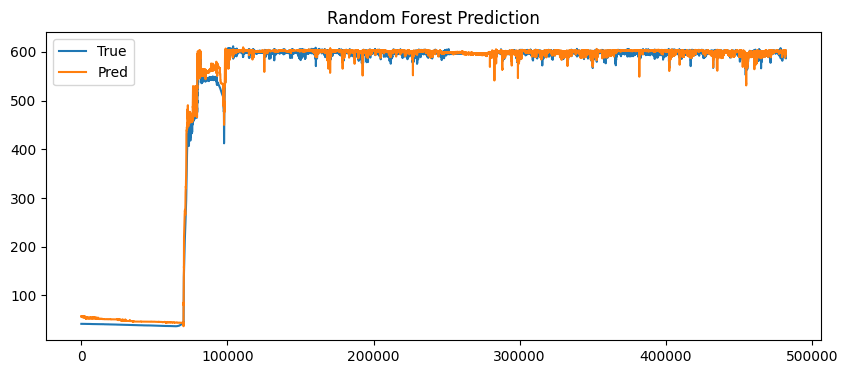

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error

testdata = pd.read_csv("../datasets/test_denoised.csv")
x_val = scaler_X.fit_transform(testdata[feature_cols])
y_val = scaler_y.fit_transform(testdata[target_cols])

y_pred = best_model.predict(x_val)


# 还原预测结果
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1))

# 评估
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)):.4f}")
print(f"R2 Score: {r2_score(y_test_inv, y_pred_inv):.4f}")
print(f"MAE: {mae:.4f}")



plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Pred')
plt.title('Random Forest Prediction')
plt.legend()
plt.show()


In [ ]:
explainer1 = shap.Explainer(best_model, X_train)
shap_values1 = explainer1(X_train, check_additivity=False)


In [ ]:
shap.initjs()  # 初始化JS
shap.force_plot(explainer1.expected_value, shap_values1, X_train,show=False)

In [ ]:
shap.plots.beeswarm(shap_values1)

In [ ]:
shap.summary_plot(
    shap_values1,         # 第一个目标的 shap 值
    X_train,                  # 原始未缩放的特征值
    feature_names=feature_cols,
    plot_type="bar",
    show=True
)
